In [1]:
!python -m pip install spacy==2.3.2 -q

     |████████████████████████████████| 9.9 MB 7.6 MB/s 
     |████████████████████████████████| 2.1 MB 42.9 MB/s 


In [2]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.3 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051301 sha256=a8a3d6d95631fee1f1862ab4230a559159f3c9d69c6b071a45edbc4589ff5494
  Stored in directory: /tmp/pip-ephem-wheel-cache-79ge9lml/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [1]:
import re
import numpy as np
import pandas as pd
import string

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
import spacy

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [3]:
PATH = '/content/drive/MyDrive/Studia II Stopnia/ZUM/zaliczenie'

In [4]:
DATASET_COLUMNS=['text','sentiment']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(f'{PATH}/movie.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,text,sentiment
17300,First of all: I love good Splattermovies and a...,0
22716,"First of all, the entire script is mostly impr...",1
10954,Or that's what the filmmakers would like you t...,0
38110,I bought this movie from Gamestop's discount u...,0
10577,"I saw this piece of garbage on AMC last night,...",0


In [5]:
data = df.copy(deep=True)

In [8]:
data['sentiment'].unique()

array(['0', '1'], dtype=object)

In [7]:
data.drop(index=0, inplace=True)

In [9]:
data.size

80000

In [10]:
data

,text,sentiment
1,I grew up (b. 1965) watching and loving the Th...,0
2,"When I put this movie in my DVD player, and sa...",0
3,Why do people who do not know what a particula...,0
4,Even though I have great interest in Biblical ...,0
5,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39996,"""Western Union"" is something of a forgotten cl...",1
39997,This movie is an incredible piece of work. It ...,1
39998,My wife and I watched this movie because we pl...,0
39999,"When I first watched Flatliners, I was amazed....",1


In [11]:
data.sentiment = data.sentiment.astype('int32')

In [12]:
data['text'] = data['text'].str.lower()
data['text'].head()

1    i grew up (b. 1965) watching and loving the th...
2    when i put this movie in my dvd player, and sa...
3    why do people who do not know what a particula...
4    even though i have great interest in biblical ...
5    im a die hard dads army fan and nothing will e...
Name: text, dtype: object

In [2]:
nlp = spacy.load('en_core_web_md')

In [13]:
stopwordlist = nlp.Defaults.stop_words

In [14]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwordlist])

data['text'] = data['text'].apply(cleaning_stopwords)
data['text'].head()

1    grew (b. 1965) watching loving thunderbirds. m...
2    movie dvd player, sat coke chips, expectations...
3    people know particular time past like feel nee...
4    great interest biblical movies, bored death mi...
5    im die hard dads army fan change that. got tap...
Name: text, dtype: object

In [15]:
punctuations_list = string.punctuation
punctuations_list

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [17]:
data['text'] = data['text'].apply(cleaning_punctuations)
data['text'].tail()

39996    western union forgotten classic western reason...
39997    movie incredible piece work explores nook cran...
39998    wife watched movie plan visit sicily stromboli...
39999    watched flatliners amazed necessary features g...
40000    film good gross estimated 95000000 award nomin...
Name: text, dtype: object

In [18]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(cleaning_repeating_char)

In [19]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(cleaning_URLs)
data['text'].head()

1    grew b1965 watching loving thunderbirds mates ...
2    movie dvd player sat coke chips expectations h...
3    people know particular time past like feel nee...
4    great interest biblical movies bored death min...
5    im die hard dads army fan change that got tape...
Name: text, dtype: object

In [20]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(cleaning_numbers)
data['text'].tail()

39996    western union forgotten classic western reason...
39997    movie incredible piece work explores nook cran...
39998    wife watched movie plan visit sicily stromboli...
39999    watched flatliners amazed necessary features g...
40000    film good gross estimated  award nominations j...
Name: text, dtype: object

In [21]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [22]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data['text'] = data['text'].apply(lemmatizer_on_text)
data['text'].head()

1    grew b watching loving thunderbirds mates scho...
2    movie dvd player sat coke chips expectations h...
3    people know particular time past like feel nee...
4    great interest biblical movies bored death min...
5    im die hard dads army fan change that got tape...
Name: text, dtype: object

In [23]:
X = data.text
y = data.sentiment

In [27]:
X

1        grew b watching loving thunderbirds mates scho...
2        movie dvd player sat coke chips expectations h...
3        people know particular time past like feel nee...
4        great interest biblical movies bored death min...
5        im die hard dads army fan change that got tape...
                               ...                        
39996    western union forgotten classic western reason...
39997    movie incredible piece work explores nook cran...
39998    wife watched movie plan visit sicily stromboli...
39999    watched flatliners amazed necessary features g...
40000    film good gross estimated  award nominations j...
Name: text, Length: 40000, dtype: object

In [25]:
uniq = set()

In [26]:
for i in X:
  j = pd.DataFrame(i.split())
  j.apply(uniq.update)

In [33]:
len(uniq)

158618

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=len(uniq))
vectorizer.fit(X_train)
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))

No. of feature_words:  158618


In [64]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [30]:
max_word = max([len(s.split()) for s in X])
max_word

1358

In [31]:
max_len = max([len(s) for s in X])
max_len

8901

In [61]:
def model_Evaluate(model):
  y_pred = model.predict(X_test)

  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1} {v2}' for v1, v2 in zip(group_names, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

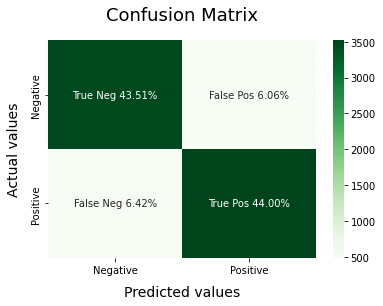

In [65]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_1 = BNBmodel.predict(X_test)

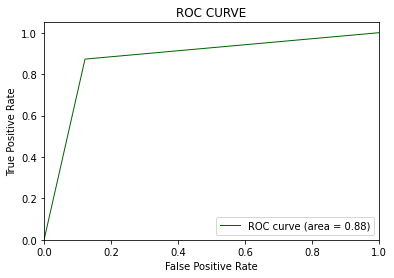

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

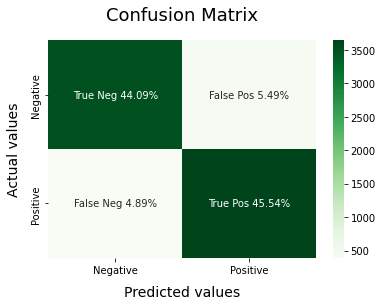

In [67]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_2 = SVCmodel.predict(X_test)

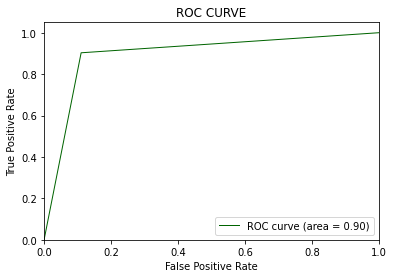

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

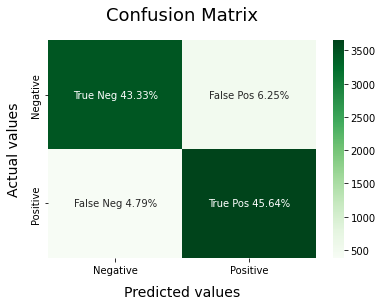

In [69]:
LRmodel = LogisticRegression()
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_3 = LRmodel.predict(X_test)

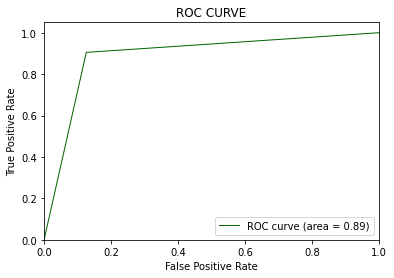

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [39]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [50]:
print(X_train.shape)
print(X_test.shape)

(32000, 100)
(8000, 100)


In [55]:
vocab_size

139897

In [43]:
from numpy import array
from numpy import asarray
from numpy import zeros

emb_dic = dict()
glove_file = open(f'{PATH}/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    emb_dic [word] = vector_dimensions
glove_file.close()

In [44]:
emb_mtx = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    emb_vec = emb_dic.get(word)
    if emb_vec is not None:
        emb_mtx[index] = emb_vec

In [45]:
model = Sequential()
emb_l = Embedding(vocab_size, 100, weights=[emb_mtx], input_length=maxlen , trainable=False)
model.add(emb_l)
model.add(LSTM(64))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          13989700  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 14,032,005
Trainable params: 42,305
Non-trainable params: 13,989,700
_________________________________________________________________
None


In [54]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=2, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/7
200/200 - 13s - loss: 0.5368 - acc: 0.7229 - val_loss: 0.4729 - val_acc: 0.7875 - 13s/epoch - 64ms/step
Epoch 2/7
200/200 - 6s - loss: 0.4414 - acc: 0.8009 - val_loss: 0.4383 - val_acc: 0.7975 - 6s/epoch - 28ms/step
Epoch 3/7
200/200 - 6s - loss: 0.4042 - acc: 0.8234 - val_loss: 0.3850 - val_acc: 0.8281 - 6s/epoch - 28ms/step
Epoch 4/7
200/200 - 6s - loss: 0.3669 - acc: 0.8377 - val_loss: 0.3665 - val_acc: 0.8394 - 6s/epoch - 28ms/step
Epoch 5/7
200/200 - 5s - loss: 0.3499 - acc: 0.8494 - val_loss: 0.3620 - val_acc: 0.8442 - 5s/epoch - 27ms/step
Epoch 6/7
200/200 - 6s - loss: 0.3315 - acc: 0.8582 - val_loss: 0.3435 - val_acc: 0.8528 - 6s/epoch - 28ms/step
Epoch 7/7
200/200 - 6s - loss: 0.3114 - acc: 0.8689 - val_loss: 0.3395 - val_acc: 0.8542 - 6s/epoch - 28ms/step
250/250 - 3s - loss: 0.3395 - acc: 0.8569 - 3s/epoch - 13ms/step


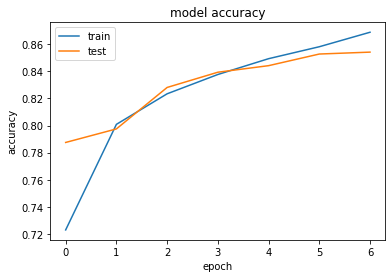

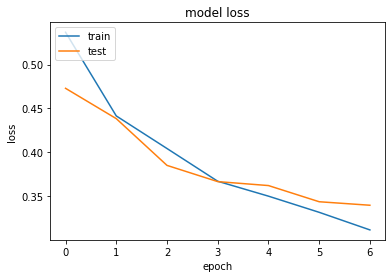

In [55]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Po przetestowaniu zwykłej gęstej sieci, sieci konwolucyjnej oraz LSTM, ta ostatnia sprawdziła się najlepiej.